In [1]:
import os
import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd

from typing import List
import numpy as np

# 1. Data
# 2. Model
# 3. Prediction
# 4. Filter data 
# 5. Training loop
# 6. Metrics
# 7. Save the model

In [2]:
genre_mapping = {
    0: "Blues",
    1: "Classical",
    2: "Country",
    3: "Disco",
    4: "Hiphop",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "Reggae",
    9: "Rock",
}

In [3]:
genre_mapping_inverse = {
    "Blues": 0,
    "Classical": 1,
    "Country": 2,
    "Disco": 3,
    "Hiphop": 4,
    "Jazz": 5,
    "Metal": 6,
    "Pop": 7,
    "Reggae": 8,
    "Rock": 9,
}

In [4]:
column_names = [
    "chroma_stft_mean",
    "chroma_stft_var",
    "rms_mean",
    "rms_var",
    "spectral_centroid_mean",
    "spectral_centroid_var",
    "spectral_bandwidth_mean",
    "spectral_bandwidth_var",
    "rolloff_mean",
    "rolloff_var",
    "zero_crossing_rate_mean",
    "zero_crossing_rate_var",
    "harmony_mean",
    "harmony_var",
    "tempo",
    "mfcc1_mean",
    "mfcc1_var",
    "mfcc2_mean",
    "mfcc2_var",
    "mfcc3_mean",
    "mfcc3_var",
    "mfcc4_mean",
    "mfcc4_var",
    "mfcc5_mean",
    "mfcc5_var",
    "mfcc6_mean",
    "mfcc6_var",
    "mfcc7_mean",
    "mfcc7_var",
    "mfcc8_mean",
    "mfcc8_var",
    "mfcc9_mean",
    "mfcc9_var",
    "mfcc10_mean",
    "mfcc10_var",
    "mfcc11_mean",
    "mfcc11_var",
    "mfcc12_mean",
    "mfcc12_var",
    "mfcc13_mean",
    "mfcc13_var",
    "mfcc14_mean",
    "mfcc14_var",
    "mfcc15_mean",
    "mfcc15_var",
    "mfcc16_mean",
    "mfcc16_var",
    "mfcc17_mean",
    "mfcc17_var",
    "mfcc18_mean",
    "mfcc18_var",
    "mfcc19_mean",
    "mfcc19_var",
    "mfcc20_mean",
    "mfcc20_var",
]

In [5]:
class MusicClassifier(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(
                in_features=input_features, out_features=256, dtype=torch.float32
            ),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=256, out_features=128, dtype=torch.float32),
            nn.GELU(),
            nn.Dropout(p=0.2),
            nn.Linear(
                in_features=128, out_features=output_features, dtype=torch.float32
            ),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

In [6]:
def training_loop(MusicClassifier: MusicClassifier):
    # TODO: Externalise this
    # Init le model
    torch.manual_seed(42)
    model = MusicClassifier(input_features=55, output_features=10)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

    def accuracy_fn(y_true, y_pred):
        correct = (
            torch.eq(input=y_true, other=y_pred).sum().item()
        )  # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
        return acc

    # Prepare data
    df = pd.read_csv("./csv/actual_dataset.csv")
    # df = pd.read_csv("/app/resources/original_dataset.csv")
    X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32)
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 125
    for epoch in range(epochs + 1):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        # loss_history.append(loss.cpu().detach().numpy())
        # acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Test
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            test_loss = loss_fn(y_test_logits, y_test)
            test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

            # 2.1 Save metrics
            # test_loss_history.append(test_loss.cpu().detach().numpy())
            # test_acc_history.append(test_acc)

        # Print out what's happening
        if epoch % 25 == 0:
            print(
                f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%"
            )

    # if epoch == 125:
    cm = confusion_matrix(y_test, y_test_pred.numpy())
    ConfusionMatrixDisplay(cm).plot()
    # Save the model
    torch.save(obj=model.state_dict(), f="./actual_model_fast.pth")

In [7]:
def predict(
    model: MusicClassifier, df: pd.DataFrame, genre_mapping: dict[int, str], real_class: str
):
    # TODO: Rewrite
    model.eval()

    class_predictions = []
    raw_results = []
    total_rows, _ = df.shape
    for i in range(total_rows):
        # print(df.iloc[i].to_numpy().reshape(55,1))
        y_logits = model(torch.from_numpy(df.iloc[i].to_numpy().reshape(55,1).transpose()).type(torch.float32))

        y_softmax = torch.softmax(y_logits, dim=1)
        y_pred = y_softmax.argmax(dim=1)

        # print(genre_mapping[y_pred.detach().numpy()[0]])
        # print(list(torch.round(y_softmax * 1000) / 1000))

        raw_results.append(y_softmax.detach().numpy())
        class_predictions.append(genre_mapping[y_pred.detach().numpy()[0]])

    unique_values = set(class_predictions)
    actual_best = 0
    for elt in unique_values:
        if class_predictions.count(elt) > actual_best:
            actual_best = class_predictions.count(elt)
            prediction = elt
        # print(elt, class_predictions.count(elt))
    # print("Real class =>", real_class)
    # print("Results =>", genre_mapping_inverse[prediction])
    return prediction, raw_results

In [8]:
def filter_data(kept_df: pd.DataFrame, seuil: float, raw_results: list, dataframe: pd.DataFrame, real_class: int):
    for i in range(len(raw_results)):
            if raw_results[i][0][int(real_class)] > seuil:
                kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)
                kept_df['label'] = real_class
    return kept_df

In [9]:
def training_loop(MusicClassifier: MusicClassifier, df: pd.DataFrame, ):
    # Init le model
    torch.manual_seed(42)
    model = MusicClassifier(input_features=55, output_features=10)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.011)

    def accuracy_fn(y_true, y_pred):
        correct = (
            torch.eq(input=y_true, other=y_pred).sum().item()
        )  # torch.eq() calculates where two tensors are equal
        acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
        return acc

    # Prepare data
    # df = pd.read_csv("./csv/actual_dataset.csv")
    # df = pd.read_csv("/app/resources/original_dataset.csv")
    X = torch.from_numpy(df.drop(columns=["label"]).to_numpy()).type(torch.float32)
    y = torch.from_numpy(df["label"].to_numpy()).type(torch.long)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 125
    for epoch in range(epochs + 1):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        # loss_history.append(loss.cpu().detach().numpy())
        # acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Test
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_test_logits = model(X_test)
            y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            test_loss = loss_fn(y_test_logits, y_test)
            test_acc = accuracy_fn(y_pred=y_test_pred, y_true=y_test)

            # 2.1 Save metrics
            # test_loss_history.append(test_loss.cpu().detach().numpy())
            # test_acc_history.append(test_acc)

        # Print out what's happening
        if epoch == 125:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

    # if epoch == 125:
    cm = confusion_matrix(y_test, y_test_pred.numpy())
    ConfusionMatrixDisplay(cm).plot()
    # Save the model
    # torch.save(obj=model.state_dict(), f="./actual_model_fast.pth")

/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 0 | Loss: 2.28905, Acc: 12.87% | Test Loss: 1.88432, Test Acc: 35.71%
Epoch: 125 | Loss: 0.07549, Acc: 97.48% | Test Loss: 0.40389, Test Acc: 89.61%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 0 | Loss: 2.29123, Acc: 12.14% | Test Loss: 1.86889, Test Acc: 37.48%
Epoch: 125 | Loss: 0.07192, Acc: 97.64% | Test Loss: 0.36480, Test Acc: 91.42%
Epoch: 0 | Loss: 2.28967, Acc: 12.76% | Test Loss: 1.88057, Test Acc: 35.76%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.08192, Acc: 97.19% | Test Loss: 0.35233, Test Acc: 91.12%
Epoch: 0 | Loss: 2.28960, Acc: 12.55% | Test Loss: 1.87724, Test Acc: 36.42%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07692, Acc: 97.59% | Test Loss: 0.36971, Test Acc: 90.50%
Epoch: 0 | Loss: 2.29000, Acc: 12.90% | Test Loss: 1.87707, Test Acc: 36.20%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07264, Acc: 97.72% | Test Loss: 0.36062, Test Acc: 91.15%
Epoch: 0 | Loss: 2.28852, Acc: 12.36% | Test Loss: 1.85980, Test Acc: 36.53%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07414, Acc: 97.62% | Test Loss: 0.36682, Test Acc: 90.99%
Epoch: 0 | Loss: 2.28921, Acc: 13.18% | Test Loss: 1.87736, Test Acc: 35.53%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07770, Acc: 97.26% | Test Loss: 0.35914, Test Acc: 90.81%
Epoch: 0 | Loss: 2.28828, Acc: 12.53% | Test Loss: 1.85860, Test Acc: 35.80%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07343, Acc: 97.55% | Test Loss: 0.38719, Test Acc: 89.88%
Epoch: 0 | Loss: 2.28744, Acc: 12.67% | Test Loss: 1.87621, Test Acc: 35.07%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06784, Acc: 97.81% | Test Loss: 0.38024, Test Acc: 90.81%
Epoch: 0 | Loss: 2.28806, Acc: 12.23% | Test Loss: 1.85894, Test Acc: 37.04%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07452, Acc: 97.40% | Test Loss: 0.28320, Test Acc: 91.59%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 0 | Loss: 2.28784, Acc: 12.62% | Test Loss: 1.86195, Test Acc: 36.30%
Epoch: 125 | Loss: 0.06560, Acc: 97.87% | Test Loss: 0.36255, Test Acc: 91.11%
Epoch: 0 | Loss: 2.28856, Acc: 12.61% | Test Loss: 1.86208, Test Acc: 36.35%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07158, Acc: 97.69% | Test Loss: 0.41495, Test Acc: 90.96%
Epoch: 0 | Loss: 2.28989, Acc: 12.67% | Test Loss: 1.86533, Test Acc: 35.83%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07648, Acc: 97.57% | Test Loss: 0.42512, Test Acc: 90.20%
Epoch: 0 | Loss: 2.29037, Acc: 12.23% | Test Loss: 1.85427, Test Acc: 36.85%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06997, Acc: 97.66% | Test Loss: 0.37382, Test Acc: 90.51%
Epoch: 0 | Loss: 2.29140, Acc: 12.04% | Test Loss: 1.87554, Test Acc: 35.38%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07253, Acc: 97.66% | Test Loss: 0.35938, Test Acc: 91.35%
Epoch: 0 | Loss: 2.28989, Acc: 12.59% | Test Loss: 1.86548, Test Acc: 35.61%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07712, Acc: 97.15% | Test Loss: 0.38682, Test Acc: 90.20%
Epoch: 0 | Loss: 2.29045, Acc: 12.37% | Test Loss: 1.86917, Test Acc: 34.97%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07377, Acc: 97.55% | Test Loss: 0.37904, Test Acc: 90.39%
Epoch: 0 | Loss: 2.29045, Acc: 12.37% | Test Loss: 1.86917, Test Acc: 34.97%


/tmp/ipykernel_57684/1662536107.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07377, Acc: 97.55% | Test Loss: 0.37904, Test Acc: 90.39%
Epoch: 0 | Loss: 2.29012, Acc: 12.58% | Test Loss: 1.88363, Test Acc: 34.99%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06853, Acc: 97.85% | Test Loss: 0.37830, Test Acc: 91.00%
Epoch: 0 | Loss: 2.28996, Acc: 12.59% | Test Loss: 1.87226, Test Acc: 35.00%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06909, Acc: 97.83% | Test Loss: 0.37971, Test Acc: 90.67%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 0 | Loss: 2.29077, Acc: 11.93% | Test Loss: 1.85945, Test Acc: 35.66%
Epoch: 125 | Loss: 0.07243, Acc: 97.76% | Test Loss: 0.33714, Test Acc: 90.74%
Epoch: 0 | Loss: 2.28999, Acc: 12.49% | Test Loss: 1.86949, Test Acc: 34.69%


/home/payetquentin/Documents/workspace/briefs/S11_music3/.venv/lib/python3.11/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07262, Acc: 97.69% | Test Loss: 0.36419, Test Acc: 91.41%
Epoch: 0 | Loss: 2.28950, Acc: 12.70% | Test Loss: 1.86882, Test Acc: 34.46%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07632, Acc: 97.65% | Test Loss: 0.33683, Test Acc: 91.22%
Epoch: 0 | Loss: 2.28967, Acc: 12.21% | Test Loss: 1.86109, Test Acc: 35.96%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07502, Acc: 97.47% | Test Loss: 0.38806, Test Acc: 90.74%
Epoch: 0 | Loss: 2.29012, Acc: 12.63% | Test Loss: 1.86886, Test Acc: 35.28%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.08111, Acc: 97.35% | Test Loss: 0.35674, Test Acc: 91.32%
Epoch: 0 | Loss: 2.28959, Acc: 12.17% | Test Loss: 1.88091, Test Acc: 34.74%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07508, Acc: 97.57% | Test Loss: 0.36064, Test Acc: 90.38%
Epoch: 0 | Loss: 2.29098, Acc: 12.04% | Test Loss: 1.87436, Test Acc: 35.15%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.08145, Acc: 97.29% | Test Loss: 0.35378, Test Acc: 91.08%
Epoch: 0 | Loss: 2.29025, Acc: 11.49% | Test Loss: 1.87657, Test Acc: 35.77%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07060, Acc: 97.60% | Test Loss: 0.42483, Test Acc: 90.21%
Epoch: 0 | Loss: 2.28990, Acc: 12.15% | Test Loss: 1.88380, Test Acc: 34.73%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07448, Acc: 97.62% | Test Loss: 0.36271, Test Acc: 90.72%
Epoch: 0 | Loss: 2.28990, Acc: 12.15% | Test Loss: 1.88380, Test Acc: 34.73%


/tmp/ipykernel_57684/1662536107.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df, kept_df], axis=0)


Epoch: 125 | Loss: 0.07448, Acc: 97.62% | Test Loss: 0.36271, Test Acc: 90.72%
Epoch: 0 | Loss: 2.28984, Acc: 12.29% | Test Loss: 1.89252, Test Acc: 34.83%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.06927, Acc: 97.68% | Test Loss: 0.40032, Test Acc: 90.86%
Epoch: 0 | Loss: 2.29027, Acc: 12.06% | Test Loss: 1.86891, Test Acc: 36.39%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07178, Acc: 97.79% | Test Loss: 0.37317, Test Acc: 90.35%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 0 | Loss: 2.28952, Acc: 12.18% | Test Loss: 1.89452, Test Acc: 33.89%
Epoch: 125 | Loss: 0.07888, Acc: 97.54% | Test Loss: 0.36743, Test Acc: 90.70%
Epoch: 0 | Loss: 2.29113, Acc: 12.03% | Test Loss: 1.88097, Test Acc: 35.24%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07483, Acc: 97.47% | Test Loss: 0.34903, Test Acc: 91.86%
Epoch: 0 | Loss: 2.28853, Acc: 12.23% | Test Loss: 1.89188, Test Acc: 34.78%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07637, Acc: 97.64% | Test Loss: 0.41560, Test Acc: 91.38%
Epoch: 0 | Loss: 2.28964, Acc: 11.98% | Test Loss: 1.87727, Test Acc: 35.72%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07430, Acc: 97.37% | Test Loss: 0.33127, Test Acc: 91.28%
Epoch: 0 | Loss: 2.29109, Acc: 12.29% | Test Loss: 1.88042, Test Acc: 36.00%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07752, Acc: 97.52% | Test Loss: 0.38875, Test Acc: 90.88%
Epoch: 0 | Loss: 2.29102, Acc: 12.29% | Test Loss: 1.88308, Test Acc: 35.60%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07353, Acc: 97.52% | Test Loss: 0.44459, Test Acc: 89.68%
Epoch: 0 | Loss: 2.29271, Acc: 11.84% | Test Loss: 1.87163, Test Acc: 37.63%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.07057, Acc: 97.59% | Test Loss: 0.40162, Test Acc: 90.15%
Epoch: 0 | Loss: 2.29272, Acc: 11.73% | Test Loss: 1.87097, Test Acc: 38.56%


/tmp/ipykernel_57684/2568257800.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kept_df = pd.concat([kept_df, pd.DataFrame(dataframe.iloc[i].to_numpy().reshape(55,1).transpose(), columns=column_names)], axis=0)


Epoch: 125 | Loss: 0.08074, Acc: 97.20% | Test Loss: 0.43842, Test Acc: 89.98%


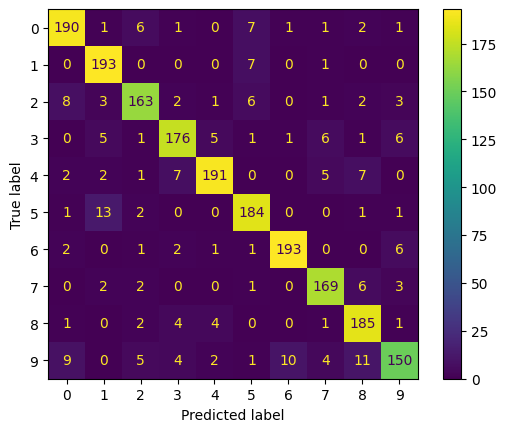

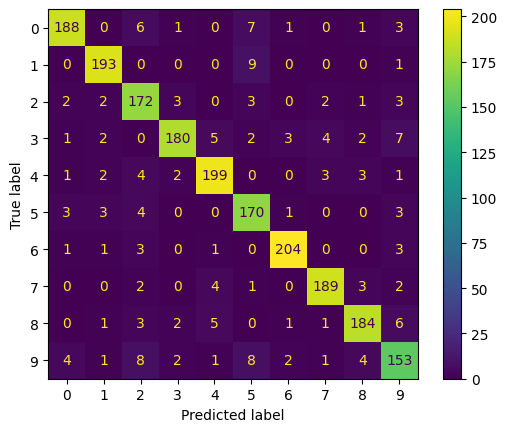

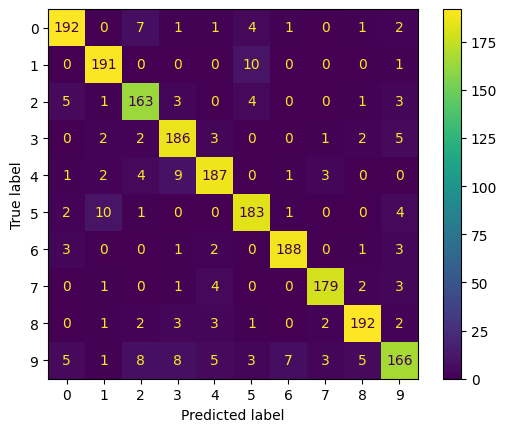

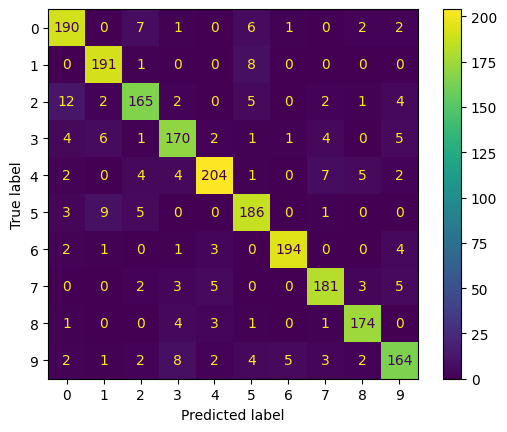

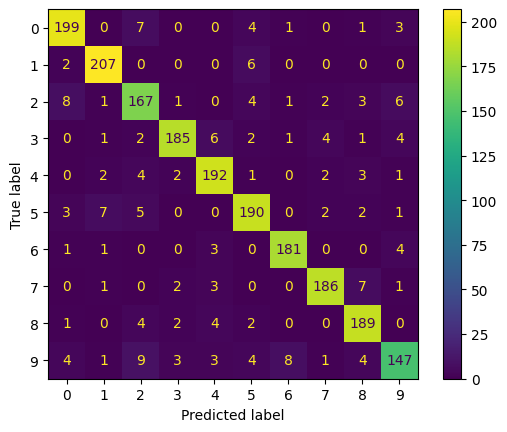

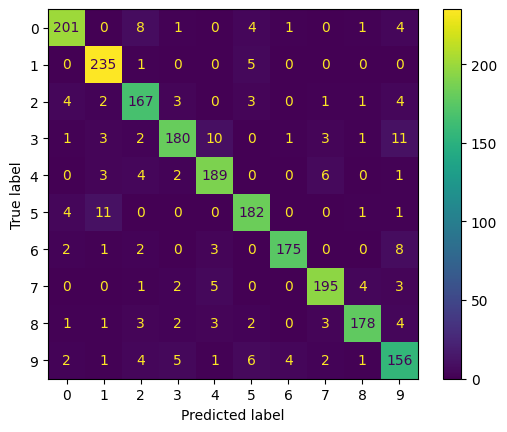

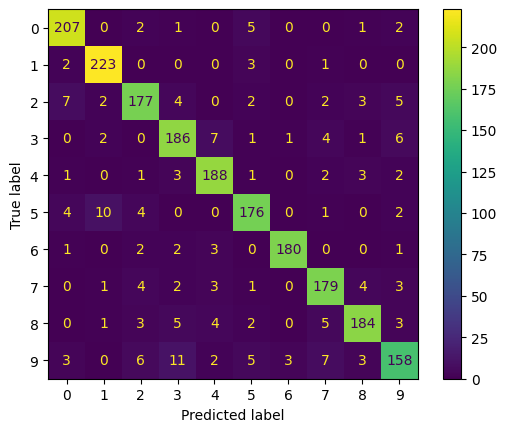

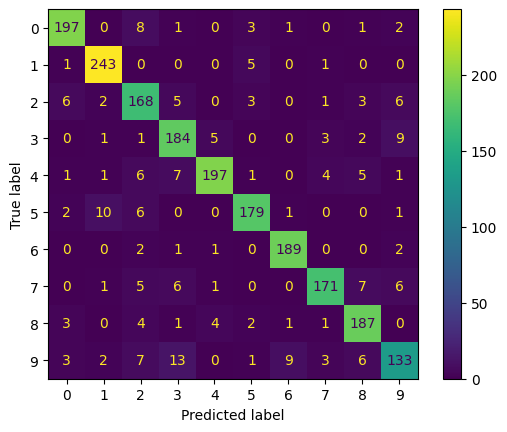

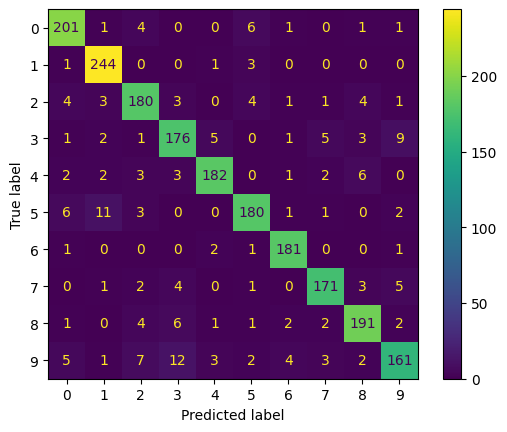

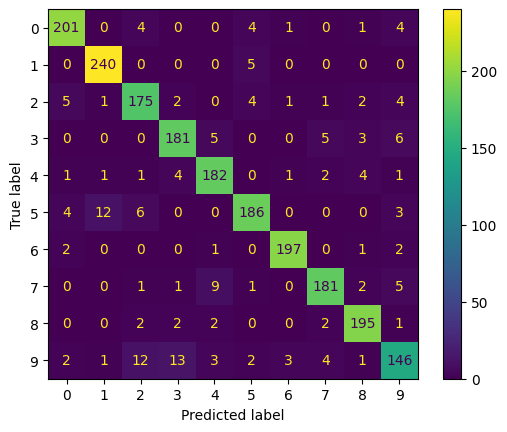

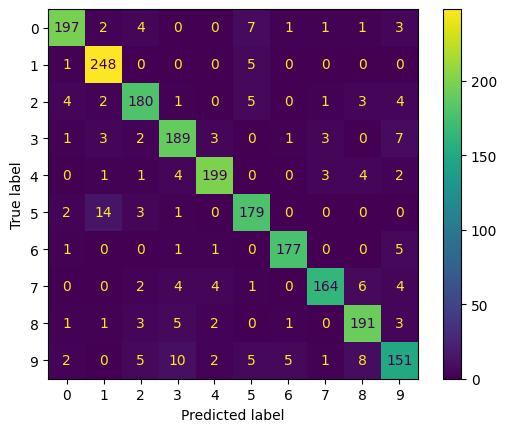

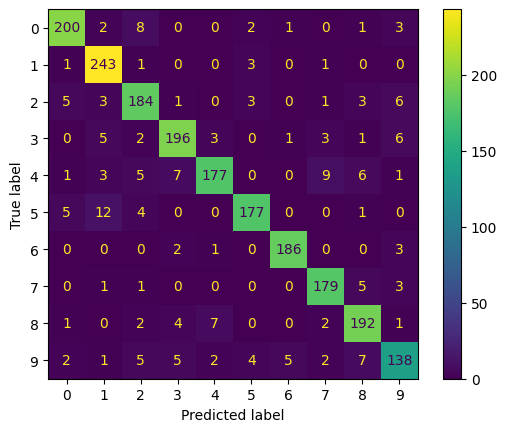

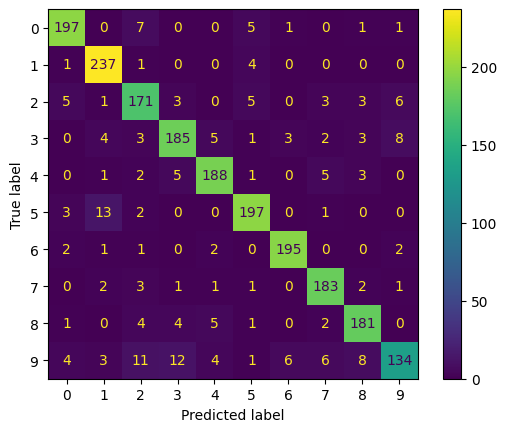

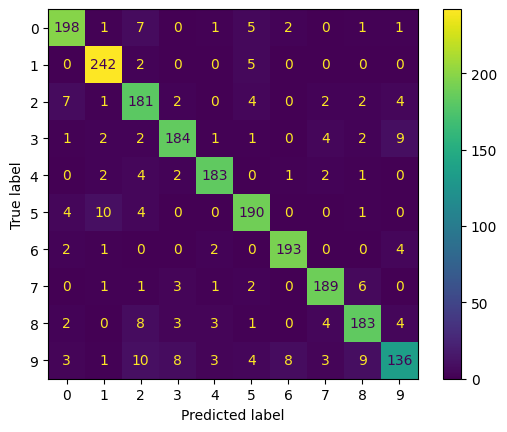

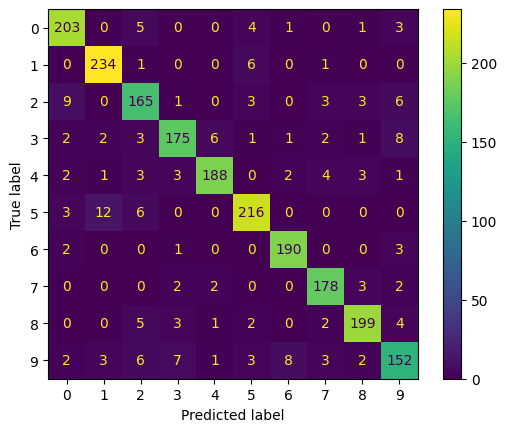

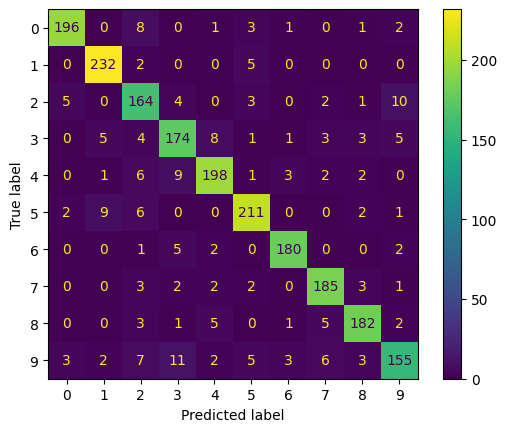

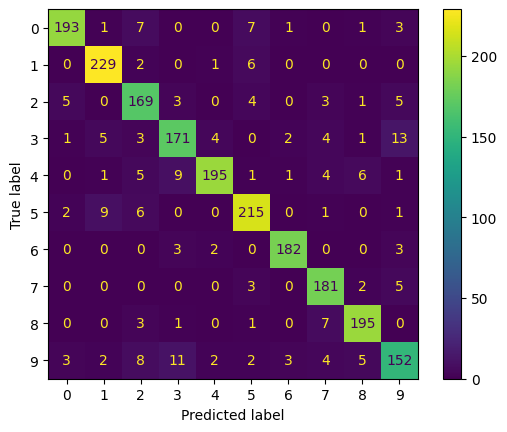

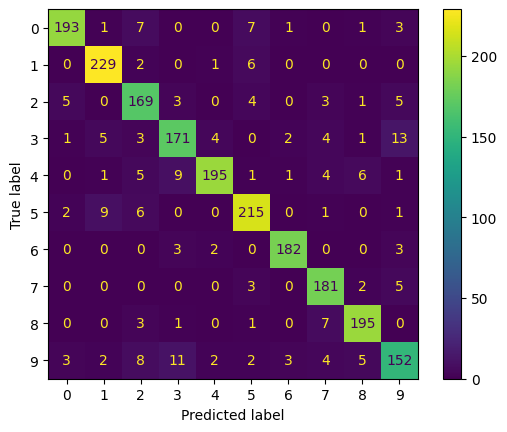

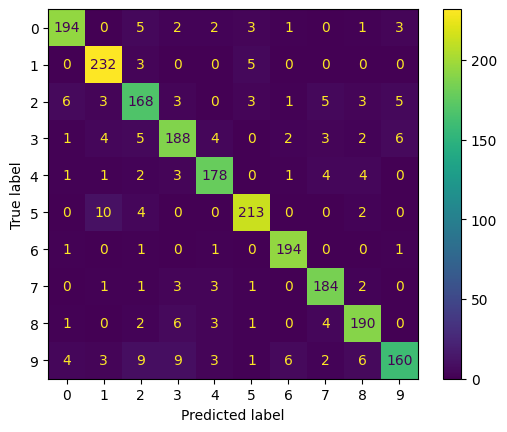

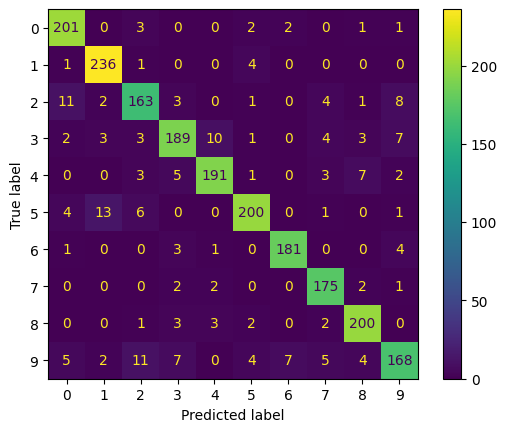

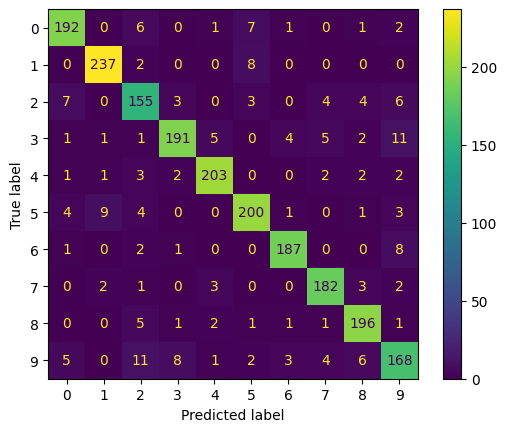

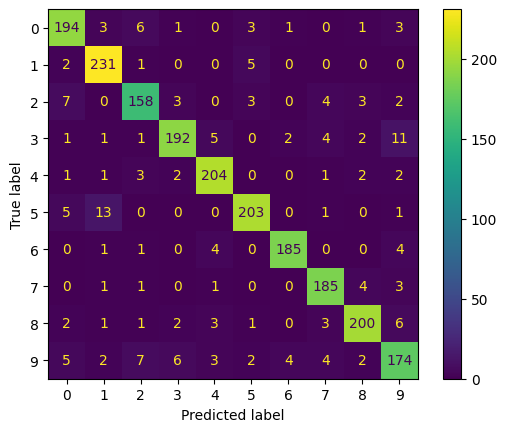

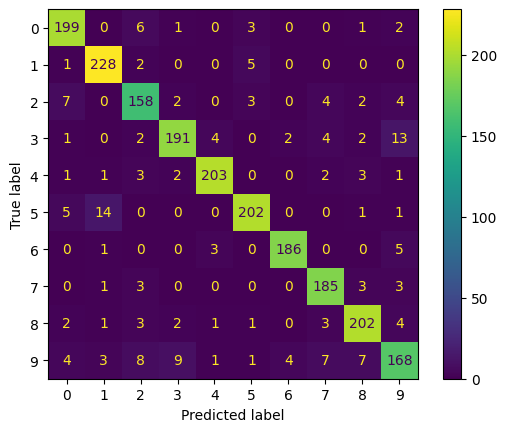

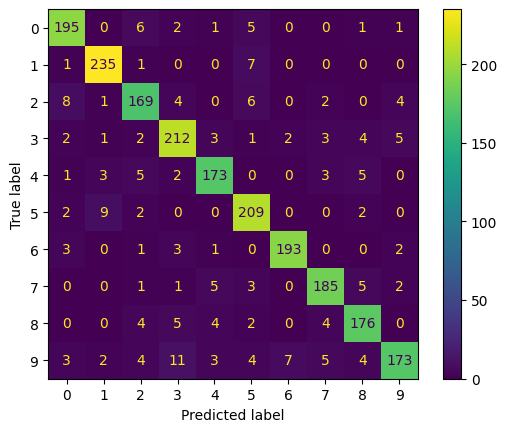

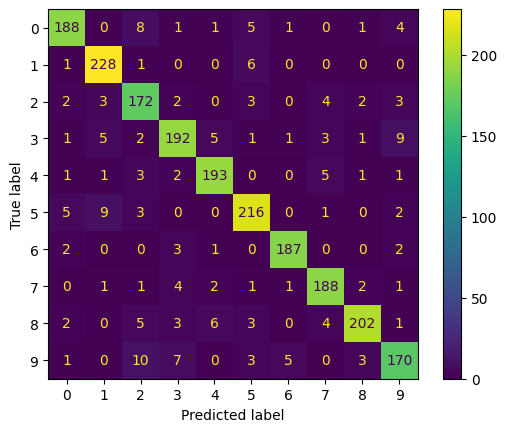

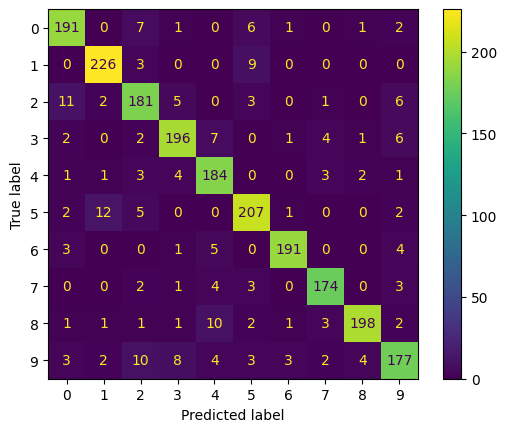

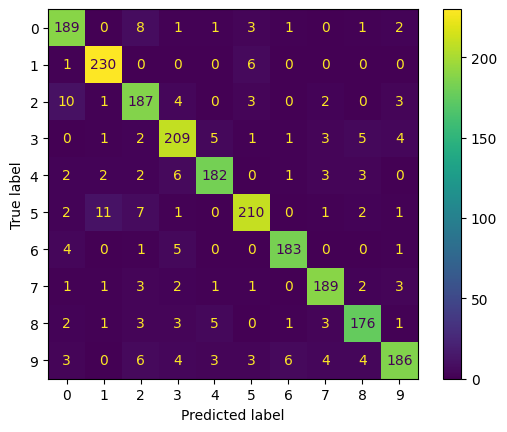

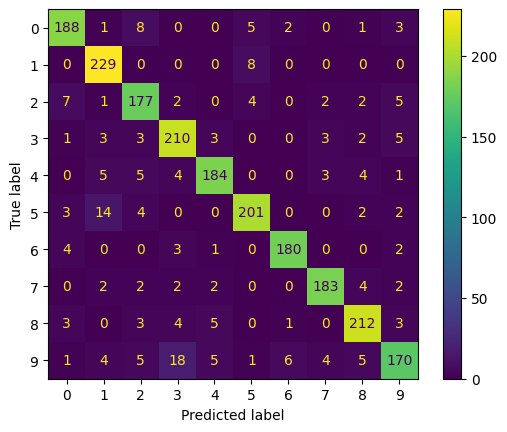

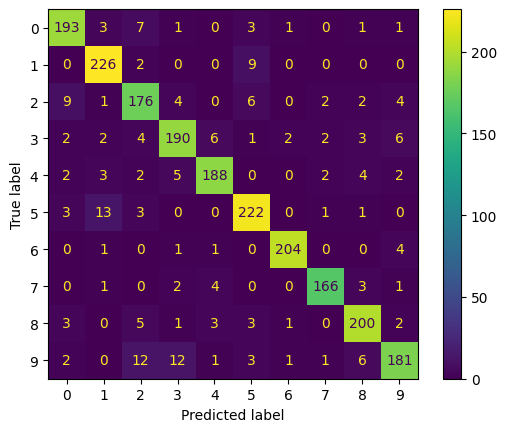

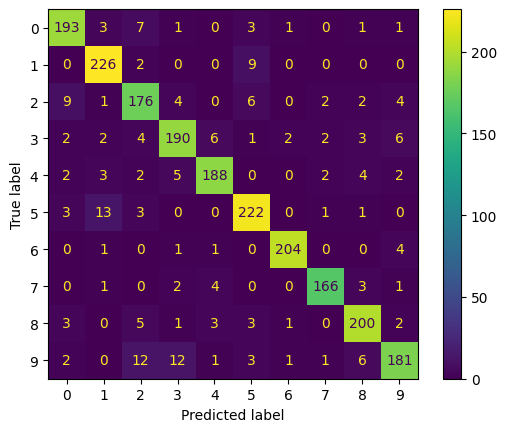

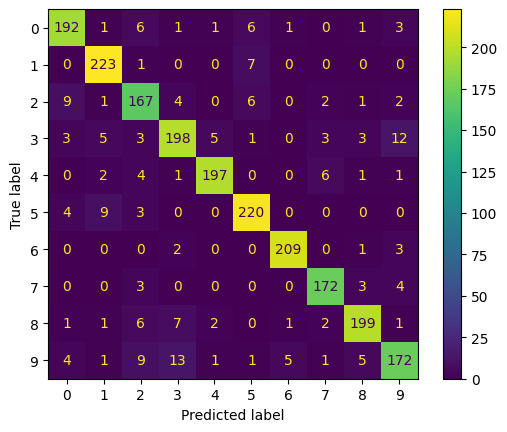

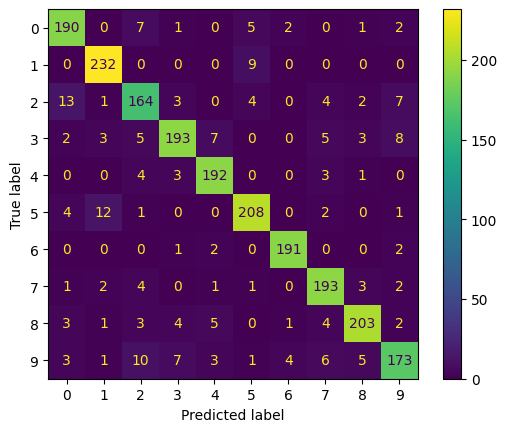

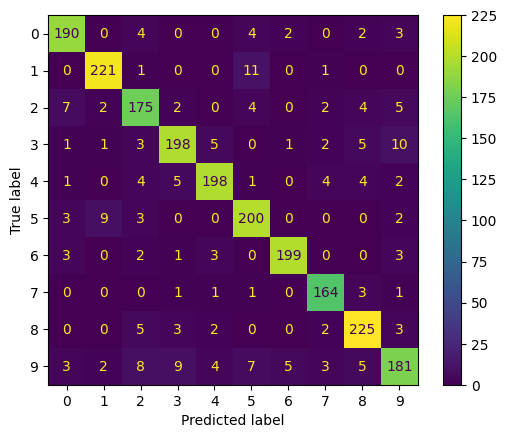

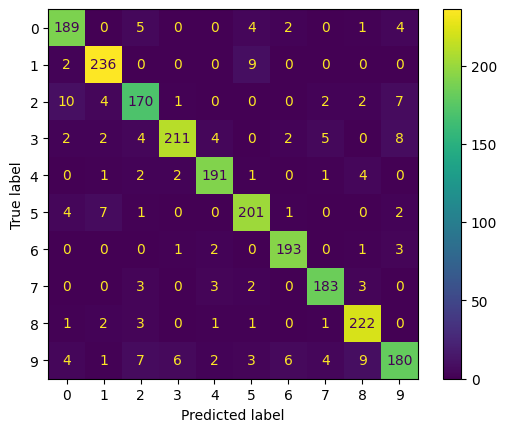

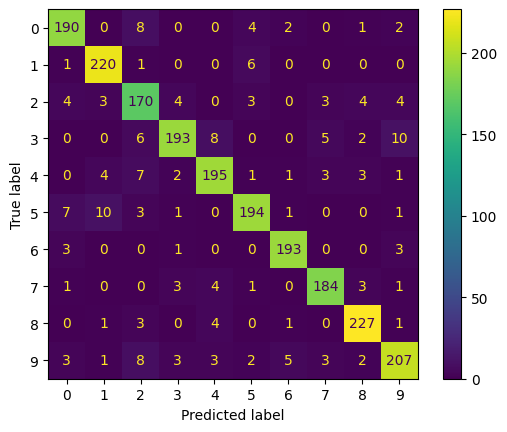

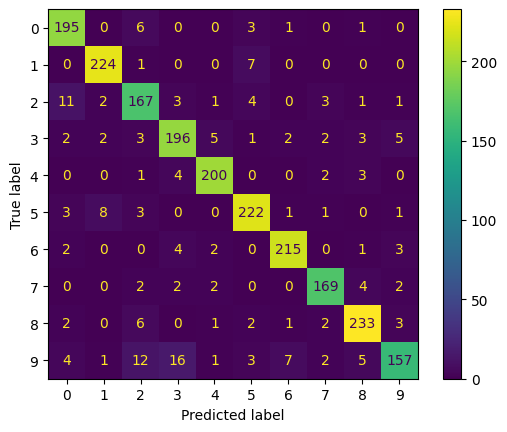

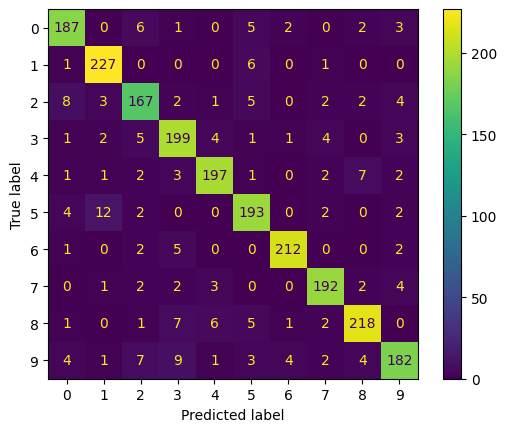

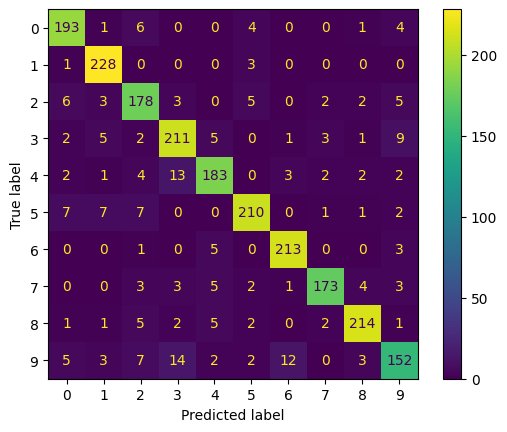

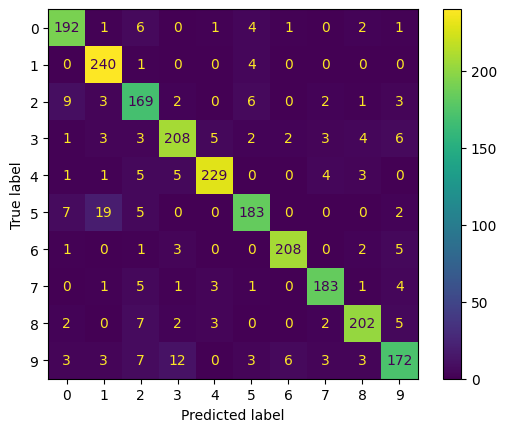

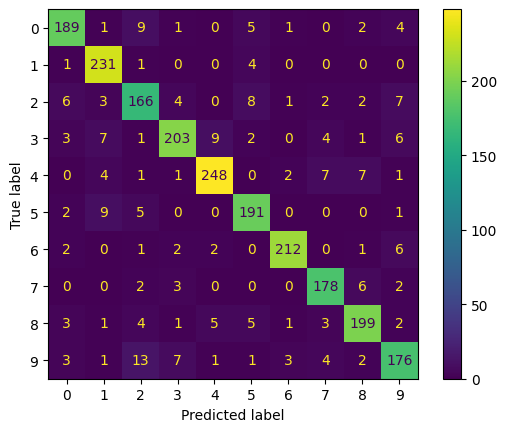

In [10]:
# 1. Data
seuil = 0.1 # ! Boucler en changeant le seuil
base_df = pd.read_csv('./resources/original_dataset.csv')
for genre in os.listdir('./extracted_drive_dataset/'):
    for extracted_features in os.listdir(f'./extracted_drive_dataset/{genre}/'):
            kept_df = pd.DataFrame(columns=column_names)
            dataframe = pd.read_csv(f"./extracted_drive_dataset/{genre}/{extracted_features}")
            # 2. Model
            my_model = MusicClassifier(input_features=55, output_features=10)
            my_model.load_state_dict(
                torch.load(
                    f="./resources/actual_model_fast.pth", map_location=torch.device("cpu")
                )
            )
            dataframe.drop(columns=['label'], inplace=True)
            
            # 3. Prediction
            result, raw_results = predict(my_model, dataframe, genre_mapping, real_class=genre)

            # 4. Filter new data
            kept_df = filter_data(kept_df, seuil, raw_results, dataframe, real_class=int(genre))
            
            # 4.1 Concat with original dataset
            base_df = pd.concat([base_df, kept_df], axis=0)

            # 5. Training loop
            training_loop(MusicClassifier, df=base_df)